In [1012]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [1013]:
data_set_path = "digit-recognizer/train.csv"
data = pd.read_csv(data_set_path)

In [1014]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1015]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

In [1016]:
data.shape

(42000, 785)

## Splitting dataset into Train and Test sets

In [1017]:
def split_data(dataset, train_test_ratio):
    m = len(dataset)
    n = len(dataset[0])

    split_index = int(m * train_test_ratio)

    data_test = dataset[0:split_index].T
    Y_test = data_test[0]
    X_test = data_test[1:n]

    data_train = dataset[split_index:m].T
    Y_train = data_train[0]
    X_train = data_train[1:n]

    return X_train, Y_train, X_test, Y_test

train_test_ratio = 1/50
X_train, Y_train, X_test, Y_test = split_data(data, train_test_ratio)

In [1018]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(784, 41160)
(41160,)
(784, 840)
(840,)


## Feature scalling with min-max method

In [1019]:
def min_max_scaling(X, X_min=None, X_max=None):
    if X_min is None:
        X_min = np.min(X, axis=0)
    if X_max is None:
        X_max = np.max(X, axis=0)

    X_scaled = (X - X_min) / (X_max - X_min)

    return X_scaled

X_train = min_max_scaling(X_train)
X_test = min_max_scaling(X_test)

In [1020]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(784, 41160)
(41160,)
(784, 840)
(840,)


## Weight and bias initialization with normalization

In [1021]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2

## Activation functions, ReLU and Softmax 

In [1022]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_deriv(Z):
    # ReLU is computationally more efficient compared to some other activation funtions, reason to used in hidden layers
    return Z > 0

## Encoding the labels with OneHotEncoding
####  [7],   [1]... ---> [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [1023]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

Y_train_ = one_hot(Y_train)
print(Y_train_.shape)

(10, 41160)


## Define the Forward and Backward propagation functions

In [1024]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [1025]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m_size = X.shape[1] 
    
    # backward pass for the layer 02
    dE2 = A2 - Y_train_ 
    # The softmax derivative is not explicitly used in the second layer, to simplifies the derivative computation during backpropagation
    dW2 = 1 / m_size * dE2.dot(A1.T)
    db2 = 1 / m_size * np.sum(dE2)

    # backward pass for the layer 01
    dA1 = W2.T.dot(dE2)
    dE1 = dA1 * ReLU_deriv(Z1)
    db1 = 1 / m_size * np.sum(dE1)
    dW1 = 1 / m_size * dE1.dot(X.T)
    
    return dW1, db1, dW2, db2

## Updating weights and bias

In [1026]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1    
    W2 = W2 - learning_rate * dW2  
    b2 = b2 - learning_rate * db2    
    return W1, b1, W2, b2

In [1027]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

## Gradient descent function

In [1028]:
History = {
    "accuracy":list(),
    "loss":list(),
}

def gradient_descent(X, Y, learning_rate, iterations, batch_size):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 10 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            History["accuracy"].append(accuracy)
            print(f"Iteration: {i}, Accuracy: {accuracy}")

    return W1, b1, W2, b2

## Model training

In [1029]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 2500, 32)

Iteration: 0, Accuracy: 0.11802721088435374
Iteration: 10, Accuracy: 0.29409620991253643
Iteration: 20, Accuracy: 0.4277696793002915
Iteration: 30, Accuracy: 0.5661807580174927
Iteration: 40, Accuracy: 0.6908649173955297
Iteration: 50, Accuracy: 0.7388969873663751
Iteration: 60, Accuracy: 0.7719630709426628
Iteration: 70, Accuracy: 0.79533527696793
Iteration: 80, Accuracy: 0.8105442176870749
Iteration: 90, Accuracy: 0.8222060252672497
Iteration: 100, Accuracy: 0.8314625850340136
Iteration: 110, Accuracy: 0.8391885325558794
Iteration: 120, Accuracy: 0.8449222546161321
Iteration: 130, Accuracy: 0.8498299319727891
Iteration: 140, Accuracy: 0.8538629737609329
Iteration: 150, Accuracy: 0.8578231292517007
Iteration: 160, Accuracy: 0.8614917395529641
Iteration: 170, Accuracy: 0.8645529640427599
Iteration: 180, Accuracy: 0.8671525753158407
Iteration: 190, Accuracy: 0.8700437317784256
Iteration: 200, Accuracy: 0.8726190476190476
Iteration: 210, Accuracy: 0.8747084548104956
Iteration: 220, Accur

Text(0.5, 1.0, 'Accuracy vs Iteration')

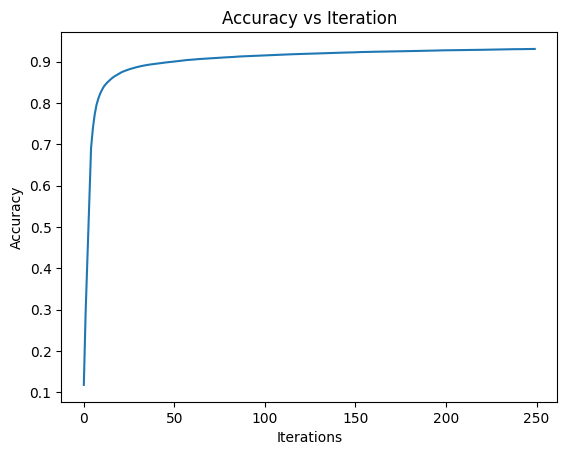

In [1030]:
plt.plot(History["accuracy"])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iteration')

In [1031]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

## Evaluate the model with test dataset

In [1032]:
dev_predictions = make_predictions(X_test, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_test)

0.9297619047619048

In [1033]:
print(W1.shape, b1.shape, W2.shape, b2.shape)

(10, 784) (10, 1) (10, 10) (10, 1)


Prediction:  [0]
Label:  0


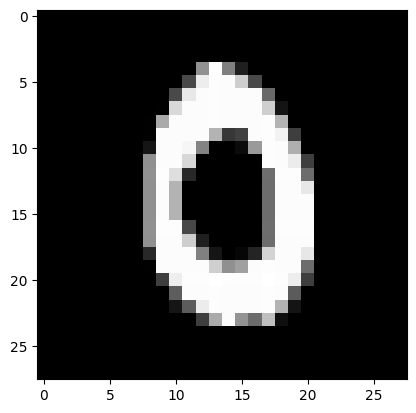

In [1034]:
test_prediction(861, W1, b1, W2, b2)

## Predicting the test.csv dataset

In [1035]:
test_set_path = "digit-recognizer/test.csv"
test = pd.read_csv(test_set_path)

In [1036]:
test.shape # no labels

(28000, 784)

In [1037]:
test = test.T
test = min_max_scaling(test)

In [1038]:
test_predictions = make_predictions(test, W1, b1, W2, b2)

In [1039]:
ImageId = np.array([x+1 for x in range(0, test_predictions.size)])
print(ImageId)

[    1     2     3 ... 27998 27999 28000]


In [1040]:
df = pd.DataFrame({"ImageId": ImageId, "Label": test_predictions})
df.to_csv("digit-recognizer/predictions.csv", index=False)

## Kaggle Results
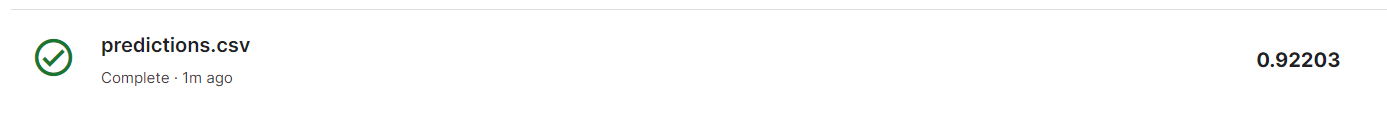

## Video Tutorials I watched

First Video : https://www.youtube.com/watch?v=b7NnMZPNIXA

Then : https://www.youtube.com/watch?v=w8yWXqWQYmU